# Classification

## Prepare the Environment

In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

In [2]:
# Import user-defined modules
import sys
from pathlib import Path
SRC_DIR = Path.cwd().parent / "src"
sys.path.append(str(SRC_DIR))

import data_utils

# Set global variables
RAW_DATA_DIR, PROCESSED_DATA_DIR = data_utils.get_data_directories()

Data directories successfully set.


### Load the Dataset

In [13]:
X = pd.read_csv(f"{PROCESSED_DATA_DIR}/scaled_encoded_global_dataset.csv")
raw = pd.read_excel(f"{RAW_DATA_DIR}/student_habits_performance.xlsx")
clean = pd.read_csv(f"{PROCESSED_DATA_DIR}/cleaned_dataset.csv")
y = raw["exam_score"]

Create the labels for the exam score, a passing rate is a grade greater than or equal to 70, otherwise, the student failed.

## Classification Model Training

We evaluated our classifier with the AUC ROC, accuracy, precision, recall, and F1 scores.

In [4]:
def evaluate_classifier(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(f"\n{name} Evaluation:")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return {
        'model': name,
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [5]:
# Obtain feature importance
def get_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_
        if importances.ndim > 1:
            importances = importances[0]
    else:
        return None

    return pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)


In [23]:
def plot_feature_importance(importance_df, model_name, top_n=10):
    """Plots the top N most important features from a model."""
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title(f"Top {top_n} Features - {model_name}")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


We used these classification model configurations for training the classifier. We trained the model with logistic regression, support vector classifier, and random forest classifier in a grid search.

In [24]:
classifier_configs = {
    'Logistic Regression': {
        'model': LogisticRegression(solver='liblinear', random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10]
        }
    },
    'Support Vector Classifier': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'Random Forest Classifier': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5]
        }
    }
}


In [25]:
def run_classification_models(X, y, feature_names=None, test_size=0.1, cv_folds=5):
    results = []
    importances = {}

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    for name, config in classifier_configs.items():
        print(f"\nTraining {name}...")

        grid = GridSearchCV(
            config['model'],
            config['params'],
            cv=KFold(n_splits=cv_folds, shuffle=True, random_state=42),
            scoring='roc_auc',
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"Best Params for {name}: {grid.best_params_}")

        result = evaluate_classifier(name, best_model, X_test, y_test)
        results.append(result)

        if feature_names is not None:
            importance_df = get_feature_importance(best_model, feature_names)
            if importance_df is not None:
                importances[name] = importance_df

    return pd.DataFrame(results), importances


In [20]:
X = pd.read_csv(f"{PROCESSED_DATA_DIR}/scaled_encoded_global_dataset.csv")
raw = pd.read_excel(f"{RAW_DATA_DIR}/student_habits_performance.xlsx")
clean = pd.read_csv(f"{PROCESSED_DATA_DIR}/cleaned_dataset.csv")
y = raw["exam_score"]

# Transform labels
y = y.apply(lambda x: 1 if x >= 70 else 0)
print(y.value_counts())
X, feature_names = data_utils.preprocessor(clean)

results_clf, importances_clf = run_classification_models(X, y, feature_names=feature_names)

# Summary
print("\nClassification Results:")
print(results_clf.sort_values(by='auc', ascending=False))

# Random Forest top features
if 'Random Forest Classifier' in importances_clf:
    print("\nRandom Forest Classifier Top Features:")
    print(importances_clf['Random Forest Classifier'].head(10))


exam_score
1    511
0    489
Name: count, dtype: int64

Training Logistic Regression...
Best Params for Logistic Regression: {'C': 10}

Logistic Regression Evaluation:
AUC-ROC: 0.9352
Accuracy: 0.8500
Precision: 0.8542
Recall: 0.8367
F1 Score: 0.8454

Training Support Vector Classifier...
Best Params for Support Vector Classifier: {'C': 10, 'kernel': 'linear'}

Support Vector Classifier Evaluation:
AUC-ROC: 0.9388
Accuracy: 0.8700
Precision: 0.8750
Recall: 0.8571
F1 Score: 0.8660

Training Random Forest Classifier...
Best Params for Random Forest Classifier: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Random Forest Classifier Evaluation:
AUC-ROC: 0.9256
Accuracy: 0.8300
Precision: 0.8333
Recall: 0.8163
F1 Score: 0.8247

Classification Results:
                       model       auc  accuracy  precision    recall  \
1  Support Vector Classifier  0.938776      0.87   0.875000  0.857143   
0        Logistic Regression  0.935174      0.85   0.854167  0.836735   
2   R


Logistic Regression Feature Importance:
                                  feature  importance
1                num__study_hours_per_day    5.076312
5               num__mental_health_rating    2.116621
4                 num__exercise_frequency    1.081149
3                        num__sleep_hours    1.002160
2              num__attendance_percentage    0.510902
7                      nom__gender_Female    0.394682
8                        nom__gender_Male    0.245476
14             nom__internet_quality_Poor    0.196632
0                                num__age    0.113395
15  nom__extracurricular_participation_No    0.077858


/tmp/ipykernel_16723/4286704722.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


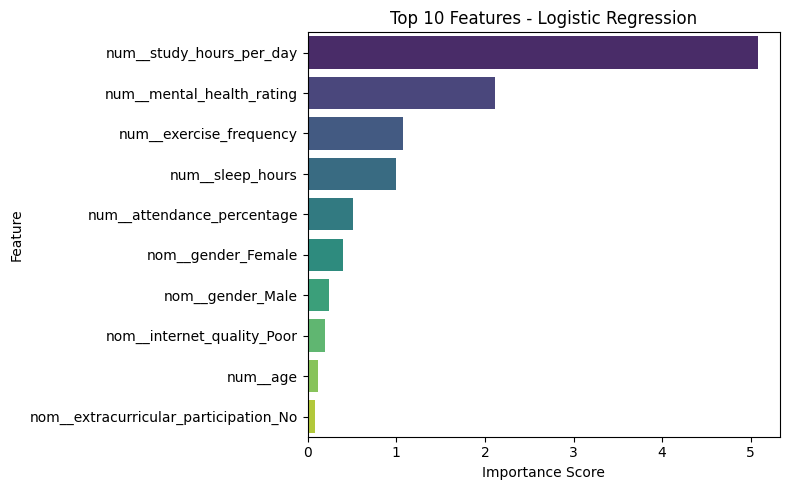


Support Vector Classifier Feature Importance:
                                  feature  importance
1                num__study_hours_per_day    3.532583
5               num__mental_health_rating    1.516333
4                 num__exercise_frequency    0.831693
3                        num__sleep_hours    0.715780
2              num__attendance_percentage    0.353504
8                        nom__gender_Male    0.128956
0                                num__age    0.120185
7                      nom__gender_Female    0.117640
15  nom__extracurricular_participation_No    0.115461
18          ord__parental_education_level    0.109566


/tmp/ipykernel_16723/4286704722.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


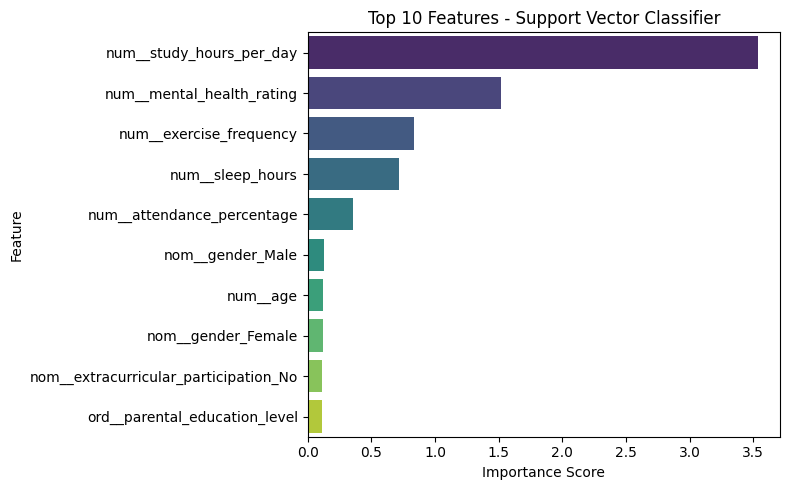


Random Forest Classifier Feature Importance:
                          feature  importance
1        num__study_hours_per_day    0.457867
5       num__mental_health_rating    0.118938
6          num__total_screen_time    0.102656
3                num__sleep_hours    0.074986
2      num__attendance_percentage    0.068672
4         num__exercise_frequency    0.041089
0                        num__age    0.030857
18  ord__parental_education_level    0.019609
17              ord__diet_quality    0.017097
13     nom__internet_quality_Good    0.008756


/tmp/ipykernel_16723/4286704722.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


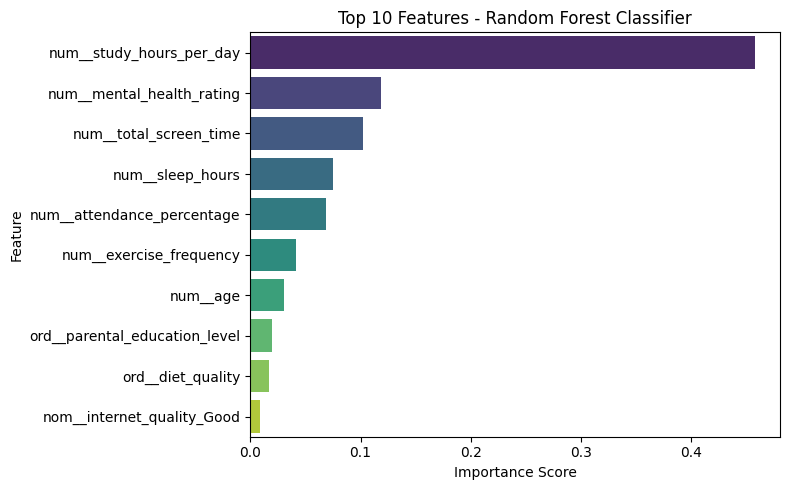

In [26]:
# Show and plot feature importance for all models that support it
for model_name, imp_df in importances_clf.items():
    print(f"\n{model_name} Feature Importance:")
    print(imp_df.head(10))  # Show top 10 in text
    plot_feature_importance(imp_df, model_name)
